<div style="text-align: right"> <b> de Charrin Théotime </b> - TP2 </div>

# TP2 - Algorithme EM et Importance Sampling

In [1]:
%pip install prettytable

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sn
import unittest 
import sklearn 
import math
import scipy.stats as stats
import sklearn.cluster as cluster
from prettytable import PrettyTable
import copy

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

# Exercice 1 - Distributions discrètes

In [4]:
def discrete_db(p,niter,values=None):
    #valeurs par défault pour X sont les entiers entre 0 et N-1, sinon peut être défini par l'utilisateur
    values=np.arange(len(p)) if values is None else values
    if math.isclose(np.sum(p),1):
        u=np.random.rand(niter)
        F=[0, *np.cumsum(p)]
        d=[np.where(F>=u[i])[0][0] for i in range(niter)]
        sampled=[values[d[i]-1] for i in range(niter)]
        return sampled
    else:
        print(f'P ({p}) is not a vector of probabilities as it sums to {np.sum(p)}')

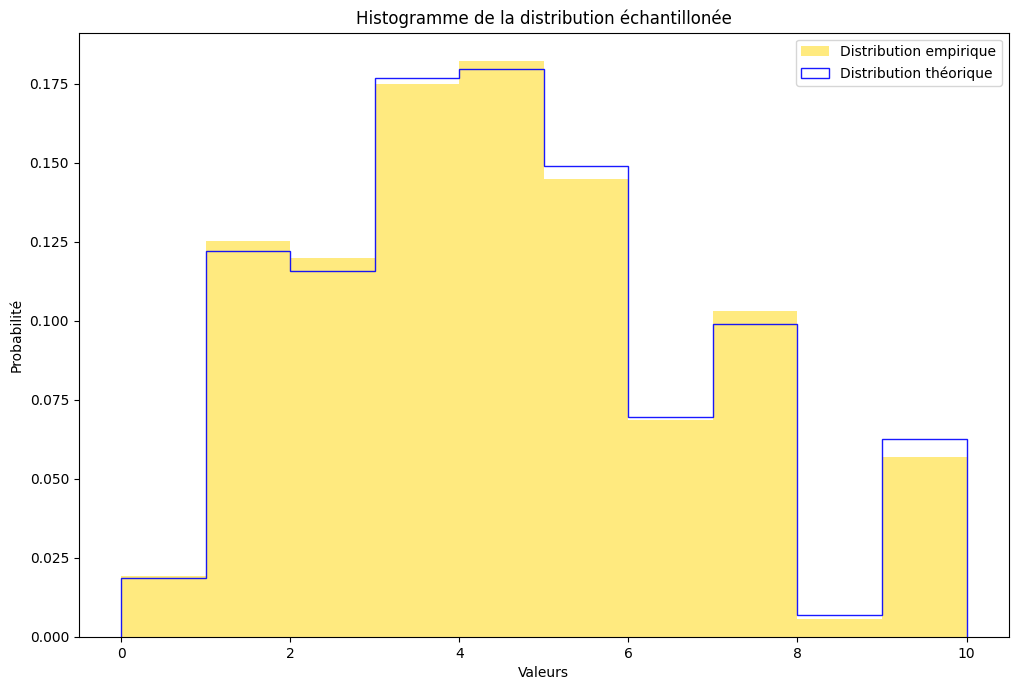

In [5]:
n=10000
rd = np.random.rand(10)
p=rd/rd.sum()
sampled=discrete_db(p,n)

plt.hist(sampled, bins=range(0,len(p)+1),density=True,label='Distribution empirique',color='gold', alpha=0.5)
#plt.plot([*[0.0], *np.arange(0,len(p))+ 1 ] , [*[0.0], *p], drawstyle='steps', label='Distribution théorique')
plt.hist([*np.arange(0,len(p))] , bins=range(0,len(p)+1), density=True, weights=p, label='Distribution théorique', color='b', alpha=0.9, ec='b', fc='None',histtype='step')
#plt.hist([*np.arange(0,len(p))] , bins=range(0,len(p)+1), density=True, weights=p, color='grey', edgecolor='black', fc="None", lw=1)
plt.title('Histogramme de la distribution échantillonée')
plt.xlabel('Valeurs')
plt.ylabel('Probabilité')
plt.legend()
plt.show()

# Exercice 2 - Mixture Gaussienne

In [6]:
def simu_gmm(n,alpha=None, mu=None, sigma=None, clusters=3, dimension=2):
    if alpha is None:
        #On attribue les poids alpha_j pour chaque gaussienne
        alpha_tmp=np.random.rand(clusters)
        alpha=alpha_tmp/np.sum(alpha_tmp)
    if mu is None:
        #On centre les nuages de points de manière aléatoire entre -1 et 1
        mu=[]
        for i in range(clusters):
            mu.append(np.random.uniform(-1,1,dimension))
        mu=np.array(mu)
    if sigma is None:
        #On crée des matrices de covariance aléatoire. 
        #Rmq : Peut créer de la donnée peu harmonieuse (covariance)
        sigma=[]
        for i in range(clusters):
            random=np.random.uniform(-1,1,(dimension,dimension))
            cov=np.dot(random.transpose(),random)
            sigma.append(cov)
        sigma=np.array(sigma)
    sample=discrete_db(alpha,n)
    sim=np.zeros(n*dimension)
    sim.shape=(n,dimension)
    n_iter=0
    label=np.array([])
    for i in np.unique(sample):
        n_i=np.sum(sample==i)
        sim[n_iter:(n_iter+n_i),:]=np.random.multivariate_normal(mu[int(i)],sigma[int(i)],n_i)
        n_iter=n_iter+n_i 
        label=np.concatenate((label,np.repeat(i,n_i)))
    return(dict(sim=np.array(sim),label=np.array(label),theta=[alpha,mu,sigma]))

In [7]:
N_points=1500
mu=[np.array([0,2]),np.array([-5,-5]),np.array([5,-6])]
#Premier nuage de points indépendants
sigma1=np.eye(2)
sigma2=np.array([1,0.7,0.7,1])
#Covariance positive
sigma2.shape=(2,2)
#Covariance négative
sigma3=np.array([1,-0.7,-0.7,1])
sigma3.shape=(2,2)
sigma=[sigma1,sigma2,sigma3]
alpha=np.array([0.6,0.15,0.25])

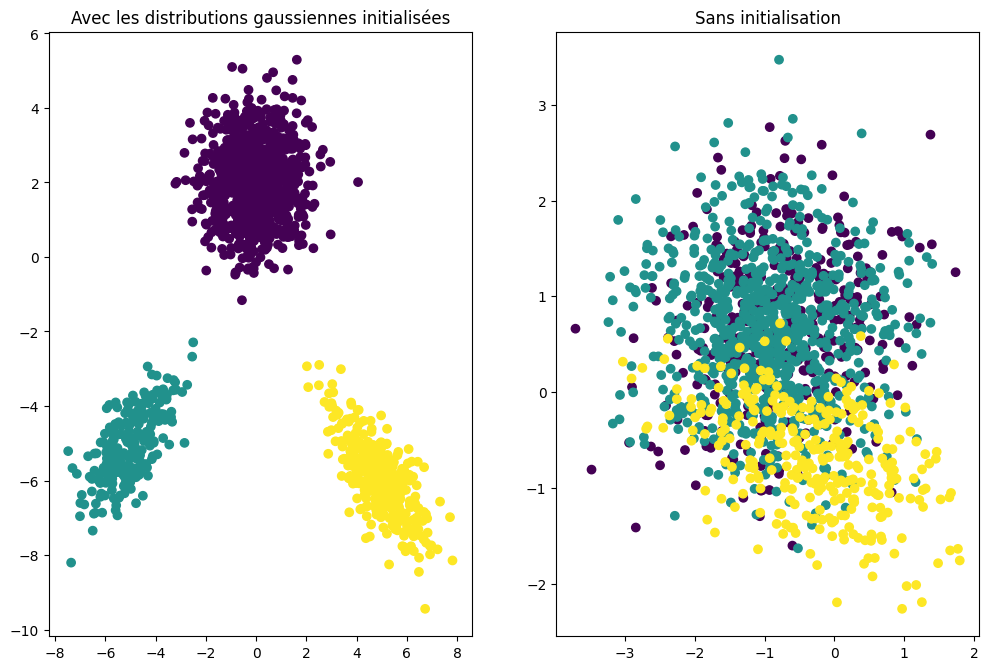

In [8]:
simu_gauss=simu_gmm(N_points,alpha, mu, sigma,dimension=2,clusters=3)
ax1=plt.subplot(121)
ax1.set_title('Avec les distributions gaussiennes initialisées')
ax1.scatter(simu_gauss["sim"][:,0],simu_gauss["sim"][:,1],c=simu_gauss["label"])
#Résultats sans initialisation
simu_gauss_random=simu_gmm(N_points, clusters=3,dimension=2)
ax2=plt.subplot(122)
ax2.set_title('Sans initialisation')
ax2.scatter(simu_gauss_random["sim"][:,0],simu_gauss_random["sim"][:,1],c=simu_gauss_random["label"])
plt.show()

In [9]:
def gmm_loglike(data,alpha,mu,sigma):
    loglike_tmp=np.zeros((data.shape[0],alpha.shape[0]))
    for j in range(alpha.shape[0]):
            loglike_tmp[:,j]=alpha[j]*stats.multivariate_normal.pdf(data,mu[j],sigma[j])
    loglike_tmp=np.apply_along_axis(lambda x: np.log(np.sum(x)),1,loglike_tmp)
    loglike=np.sum(loglike_tmp)
    return(loglike)

def Gaussian_Expect(data,alpha,mu,sigma, clusters=None,*,allowsingular:bool=False,normalize:bool=True,method='numerical'):
    clusters=alpha.shape[0] if clusters is None else clusters
    if method=='scipy':
        tau=np.zeros((data.shape[0],clusters))
        for j in range(clusters):
                tau[:,j]=alpha[j]*stats.multivariate_normal.pdf(data,mu[j],sigma[j],allow_singular=bool(allowsingular))
        if normalize:
            normalizer=np.sum(tau,1)
            tau=tau/normalizer.reshape(-1,1)

    elif method=='numerical':
        log_tautild=np.zeros((data.shape[0],clusters))
        log_sumtautild=np.zeros((data.shape[0],clusters))
        log_tau=np.zeros((data.shape[0],clusters))
        for j in range(clusters):
            #On ajoute pour chaque cluster J la log-vraisemblance de x.
            #On va diagonaliser Sigma
            vals, vecs = np.linalg.eigh(sigma[j])
            sign, logdet     = np.linalg.slogdet(sigma[j])
            valsinv    = 1./vals
            U          = vecs * np.sqrt(valsinv)
            dev        = data - mu[j]
            #On passe par la distance de Mahalanobis
            maha       = np.sum(np.square(np.dot(dev, U)),1)
            log_tautild[:,j]=np.log(alpha[j]) -0.5 * (maha + logdet)
        log_sumtautild=np.log(np.sum(np.exp(log_tautild),1))
        if normalize:
            tau=np.exp(log_tautild)/np.exp(log_sumtautild).reshape(-1,1)
        else:
            tau=np.exp(log_tautild)
    else:
        raise ValueError('error, no methods chosen')
    return(tau)
    
def Gaussian_Maxim(data,tau):
    sigma=[]
    mu=[]
    alpha=np.sum(tau,axis=0)
    alpha=alpha/np.sum(alpha)
    for j in range(tau.shape[1]):
        mu.append(np.apply_along_axis(lambda x: np.average(x,weights=tau[:,j]),0,data))
        sigma.append((tau[:,j].reshape(-1,1)*(data-mu[j])).T@(data-mu[j])/np.sum(tau[:,j]))
    return(dict(alpha=alpha,mu=mu,sigma=sigma))

def EM_Gaussian(data,max_iter=100,clusters=3,method='numerical'):
    
    kmeans=cluster.KMeans(n_clusters=clusters,init='k-means++',n_init='auto').fit(data)
    labels=kmeans.labels_
    
    loglike_seq=np.zeros(max_iter+1)
    mu=[]
    sigma=[]
    alpha=np.ones(clusters)
    
    for i in range(clusters):
        index=np.where(labels==i)[0]
        mu.append(np.apply_along_axis(np.mean,0,data[index,:]))
        sigma.append(np.cov([data[index,d] for d in range(data.shape[1])])) 
        alpha[i]=len(index)/data.shape[0]

    
    for i in range(max_iter):
        loglike_seq[i]=gmm_loglike(data,alpha,mu,sigma)
        tau=Gaussian_Expect(data,alpha,mu,sigma,clusters,method=method)
        results=Gaussian_Maxim(data,tau)
        mu=results["mu"]
        alpha=results["alpha"]
        sigma=results["sigma"]
    loglike_seq[-1]=gmm_loglike(data,alpha,mu,sigma)
    clusterid=np.apply_along_axis(np.argmax,1,tau)
    return(dict(alpha=alpha,mu=mu,sigma=sigma,tau=tau, loglike=loglike_seq,theta=[alpha,mu,sigma],clusterid=clusterid))

def Gaussian_contour_2d(data,results_EM,title="Clusters obtenus par algorithme EM",x=None,y=None,ax=None):
    if ax is None:
        fig, ax=plt.subplots(figsize=(15,15))
    #plt.figure(figsize=(10,10))
    ax.plot(data[:,0],data[:,1],'o',alpha=.6,lw=.8)
    for i in range(results_EM['alpha'].shape[0]):
        #On plotte uniquement les gaussiennes dans le cluster prédit pour éviter un comportement aberrant
        index=np.where(results_EM['clusterid']==i)[0]
        xmin = min(data[index,0])
        xmax = max(data[index,0])
        ymin = min(data[index,1])
        ymax = max(data[index,1])
        X=np.linspace(xmin,xmax)
        Y=np.linspace(ymin,ymax)
        X,Y=np.meshgrid(X,Y)
        z=stats.multivariate_normal(results_EM['mu'][i][:2],results_EM['sigma'][i][:2,:2]).pdf(np.dstack((X,Y)))
        ax.contour(X, Y, z,levels=9)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

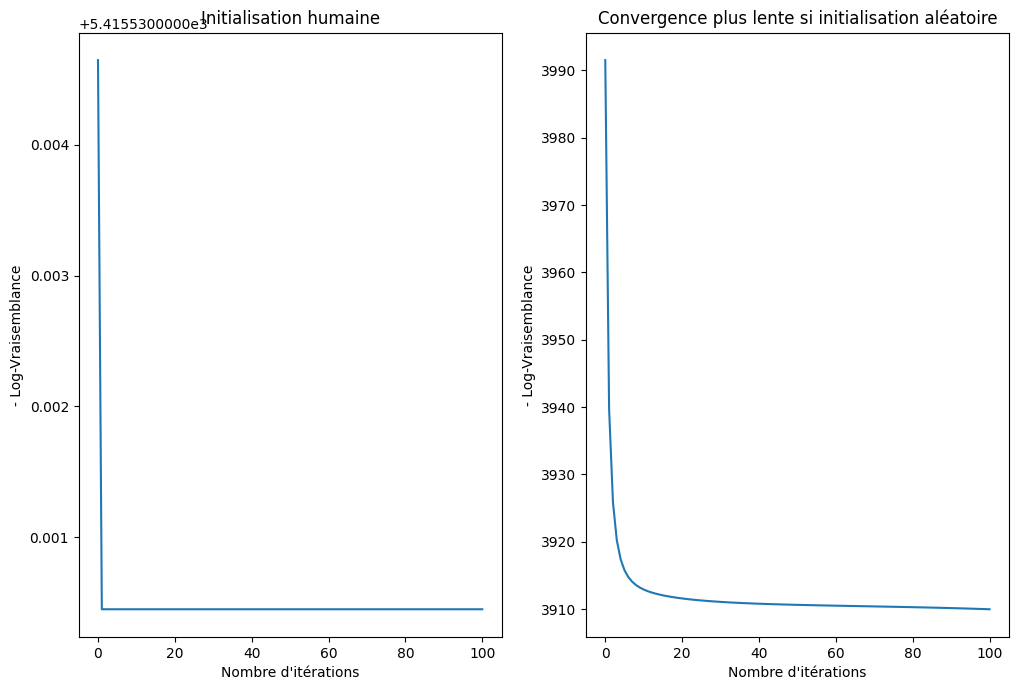

In [10]:
data_sim=simu_gauss["sim"]
data_random=simu_gauss_random["sim"]
max_iter=100
results_EM=EM_Gaussian(data_sim,max_iter,clusters=3,method='numerical')
results_EM_random=EM_Gaussian(data_random,max_iter,clusters=3)
ax1=plt.subplot(121)
ax1.set_title('Initialisation humaine')
ax2=plt.subplot(122)
ax2.set_title('Convergence plus lente si initialisation aléatoire')
ax1.plot(np.arange(0,max_iter+1),-results_EM["loglike"])
ax2.plot(np.arange(0,max_iter+1),-results_EM_random["loglike"])
ax1.set_xlabel("Nombre d'itérations")
ax2.set_xlabel("Nombre d'itérations")
ax1.set_ylabel("- Log-Vraisemblance")
ax2.set_ylabel("- Log-Vraisemblance")
plt.show()

In [11]:
#On triche en rangeant par probabilités croissantes (sinon problème de label des clusters)
#Problème : probas similaires, mauvaise estimation?
def param_evaluation(truth, results_EM):
    clusters = ['Params']+['Cluster ' + str(i+1) +' :' for i in range(len(truth[0]))]
    alpha_or=['Alpha vrai']
    alpha_es=['Alpha estimé']
    alpha_diff=['Différence de']
    mu_or=['Moyenne vraie']
    mu_es=['Moyenne estimée']
    mu_diff=['Différence de']
    sigma_or=['Covariance vraie']
    sigma_es=['Covariance estimée']
    sigma_diff=['Différence de']
    j=np.argsort(results_EM['alpha'])
    for count,i in enumerate(np.argsort(truth[0])):
        alpha_or.append(f"{truth[0][i]:.3f}")
        alpha_es.append(f"{results_EM['alpha'][j[count]]:.3f}")
        alpha_diff.append(f"{np.linalg.norm(truth[0][i]-results_EM['alpha'][j[count]]):.3f}")
        mu_or.append(["%.3f" % x for x in truth[1][i]])
        mu_es.append(["%.3f" % x for x in results_EM['mu'][j[count]]])
        mu_diff.append(f"{np.linalg.norm(truth[1][i]-results_EM['mu'][j[count]]):.3f}")
        sigma_or.append(np.round(truth[2][i],decimals=3))
        sigma_es.append(np.round(results_EM['sigma'][j[count]],decimals=3))
        sigma_diff.append(f"{np.linalg.norm(truth[2][i]-results_EM['sigma'][j[count]]):.3f}")
    t = PrettyTable(clusters)
    t.add_row(alpha_or)
    t.add_row(alpha_es)
    t.add_row(alpha_diff)
    t.add_row(mu_or)
    t.add_row(mu_es)
    t.add_row(mu_diff)
    t.add_row(sigma_or)
    t.add_row(sigma_es)
    t.add_row(sigma_diff)
    print(t)

In [12]:
param_evaluation([alpha,mu,sigma],results_EM)

+--------------------+----------------------+---------------------+---------------------+
|       Params       |     Cluster 1 :      |     Cluster 2 :     |     Cluster 3 :     |
+--------------------+----------------------+---------------------+---------------------+
|     Alpha vrai     |        0.150         |        0.250        |        0.600        |
|    Alpha estimé    |        0.147         |        0.236        |        0.617        |
|   Différence de    |        0.003         |        0.014        |        0.017        |
|   Moyenne vraie    | ['-5.000', '-5.000'] | ['5.000', '-6.000'] |  ['0.000', '2.000'] |
|  Moyenne estimée   | ['-5.041', '-5.070'] | ['4.922', '-5.914'] | ['-0.020', '2.034'] |
|   Différence de    |        0.081         |        0.116        |        0.040        |
|  Covariance vraie  |      [[1.  0.7]      |     [[ 1.  -0.7]    |       [[1. 0.]      |
|                    |      [0.7 1. ]]      |     [-0.7  1. ]]    |       [0. 1.]]      |
| Covarian

In [13]:
param_evaluation(simu_gauss_random['theta'],results_EM_random)

+--------------------+----------------------+---------------------+---------------------+
|       Params       |     Cluster 1 :      |     Cluster 2 :     |     Cluster 3 :     |
+--------------------+----------------------+---------------------+---------------------+
|     Alpha vrai     |        0.202         |        0.252        |        0.546        |
|    Alpha estimé    |        0.219         |        0.382        |        0.399        |
|   Différence de    |        0.017         |        0.130        |        0.147        |
|   Moyenne vraie    | ['-0.355', '-0.644'] | ['-0.729', '0.716'] | ['-0.914', '0.638'] |
|  Moyenne estimée   | ['-0.236', '-0.680'] | ['-0.665', '0.987'] | ['-1.134', '0.359'] |
|   Différence de    |        0.124         |        0.279        |        0.355        |
|  Covariance vraie  |   [[ 0.889 -0.308]   |    [[0.817 0.159]   |   [[ 0.77  -0.043]  |
|                    |   [-0.308  0.356]]   |    [0.159 0.66 ]]   |   [-0.043  0.553]]  |
| Covarian

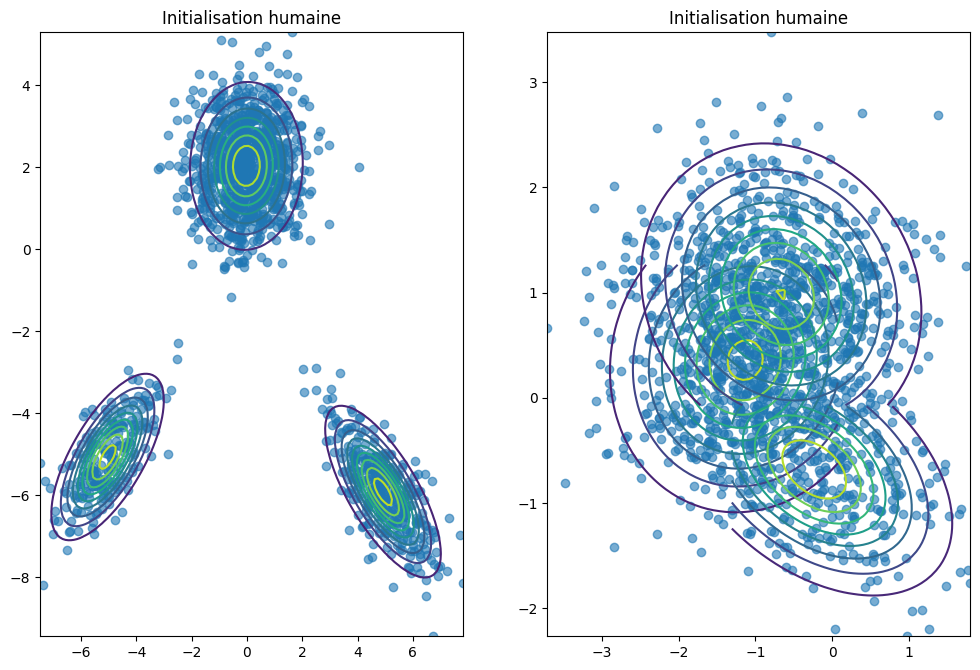

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2)
x=[data_sim, data_random]
y=[results_EM,results_EM_random]
for i in range(2):
    Gaussian_contour_2d(x[i],y[i],title="Initialisation humaine",ax=ax.flatten()[i])

In [15]:
def dof(clusters, dimension=2):
    #Pour chaque gaussienne on a une probabilité alpha, D moyennes, et (D*D-D)/2+D paramètres de covariance
    sum_dof=clusters*(1+dimension+(dimension*dimension - dimension)/2 + dimension)
    #Les alpha somment à un donc il suffit d'en connaître p-1
    dof=sum_dof-1
    return dof

In [16]:
def BIC(data, results, clusters):
    BIC=[]
    for i in np.arange(1,clusters+1):
        BIC.append(-results[i-1]['loglike'][-1]+(dof(i)*np.log(data.shape[0]))/2)
    return np.argmin(BIC)+1, np.min(BIC), BIC

(13290, 2)


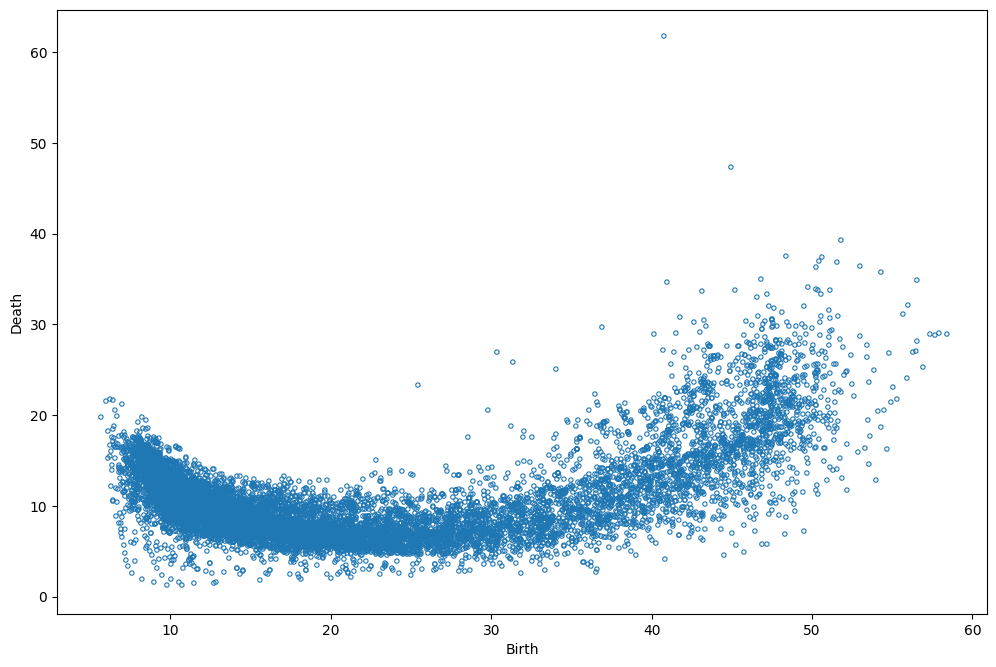

In [17]:
df19=pd.read_csv('./data/WPP2019_Period_Indicators_Medium.csv', delimiter=",",usecols=['CBR','CDR']).dropna()
print(df19.shape)
plt.scatter(df19['CBR'],df19['CDR'],marker="$\circ$",linewidths=.01)
plt.xlabel('Birth')
plt.ylabel('Death')
plt.show()

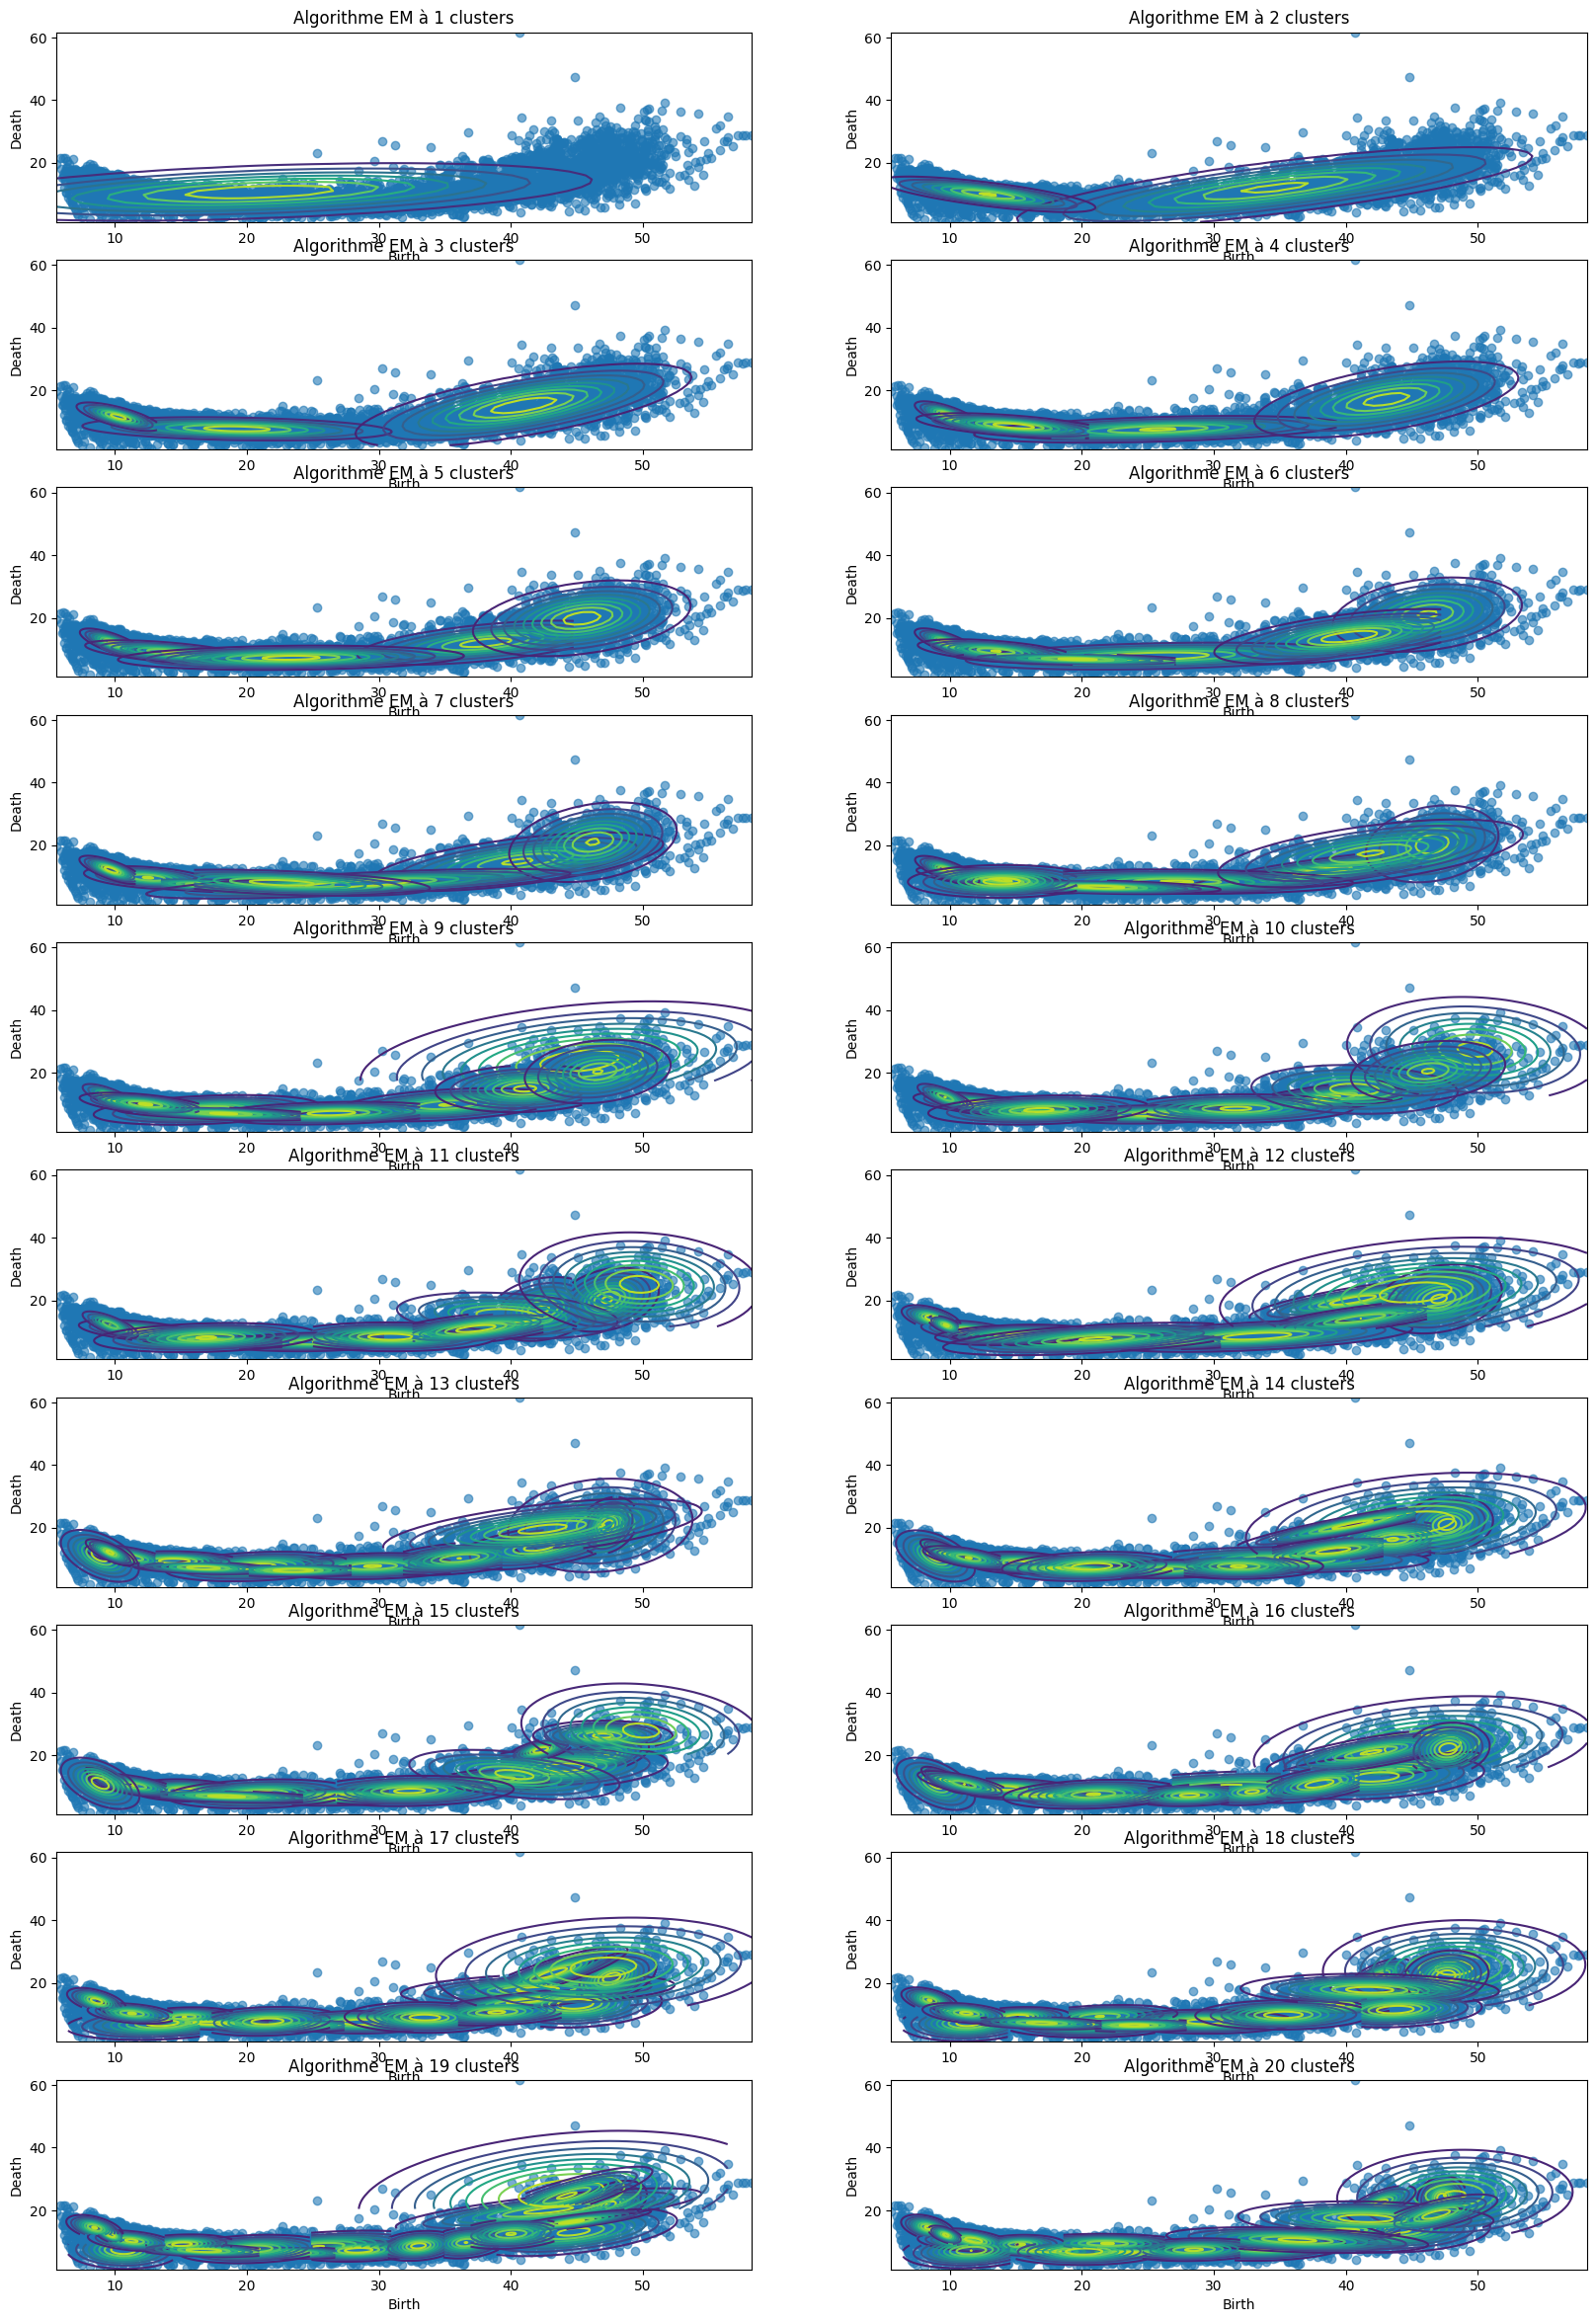

In [18]:
data19=np.array(df19)
max_cluster=20
results19=[]
nrow=10
ncols=2
fig, ax = plt.subplots(nrows=nrow, ncols=ncols,figsize=(20,30))
for i in range(max_cluster):
    results19.append(EM_Gaussian(data19, max_iter=100, clusters=i+1))
    Gaussian_contour_2d(data19,results19[i],title="Algorithme EM à " +str(i+1) + " clusters",x="Birth",y="Death",ax=ax.flatten()[i])

In [44]:
best,value,bic=BIC(data19,results19,20)
BIC(data19,results19,20)

(12,
 75692.34589843033,
 [90020.87245977962,
  79771.60737345835,
  76766.38808717598,
  76049.22898822158,
  75944.35140919067,
  75805.76763046255,
  75822.15322360133,
  75792.93332215141,
  75759.33536513627,
  75769.98585003927,
  75784.99791465841,
  75692.34589843033,
  75756.29591481146,
  75759.79220763766,
  75766.28397342951,
  75800.26654628084,
  75783.58111581401,
  75790.26333738,
  75815.61733031896,
  75845.7150936901])

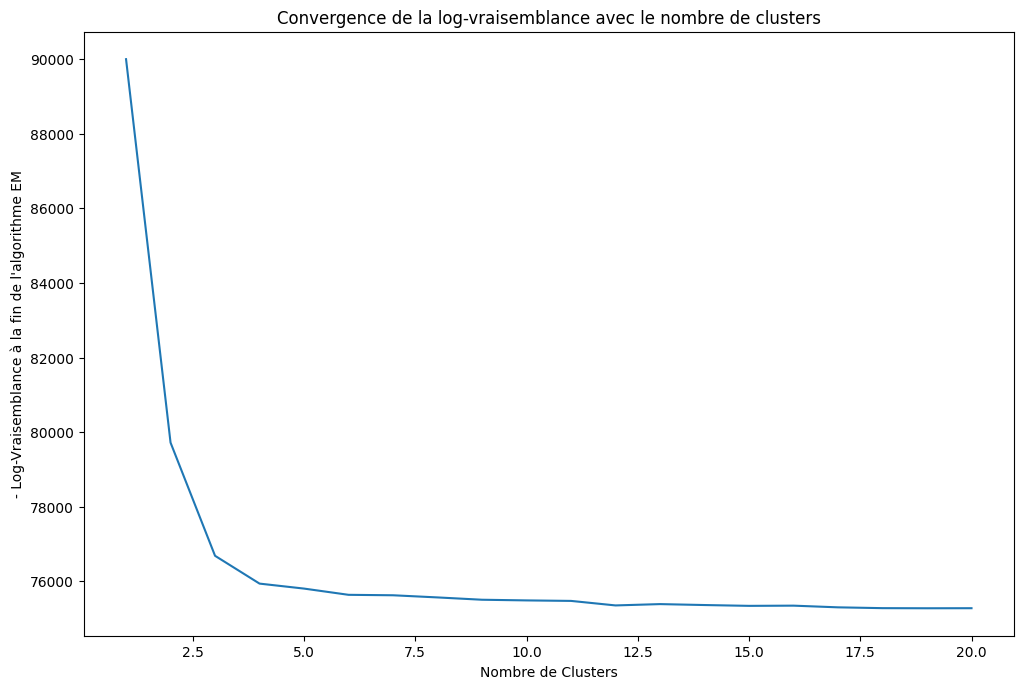

In [20]:
plt.plot(np.arange(1,max_cluster+1),[-1*results19[i]['loglike'][-1] for i in range(max_cluster)])
plt.xlabel('Nombre de Clusters')
plt.ylabel('- Log-Vraisemblance à la fin de l\'algorithme EM')
plt.title('Convergence de la log-vraisemblance avec le nombre de clusters')
plt.show()

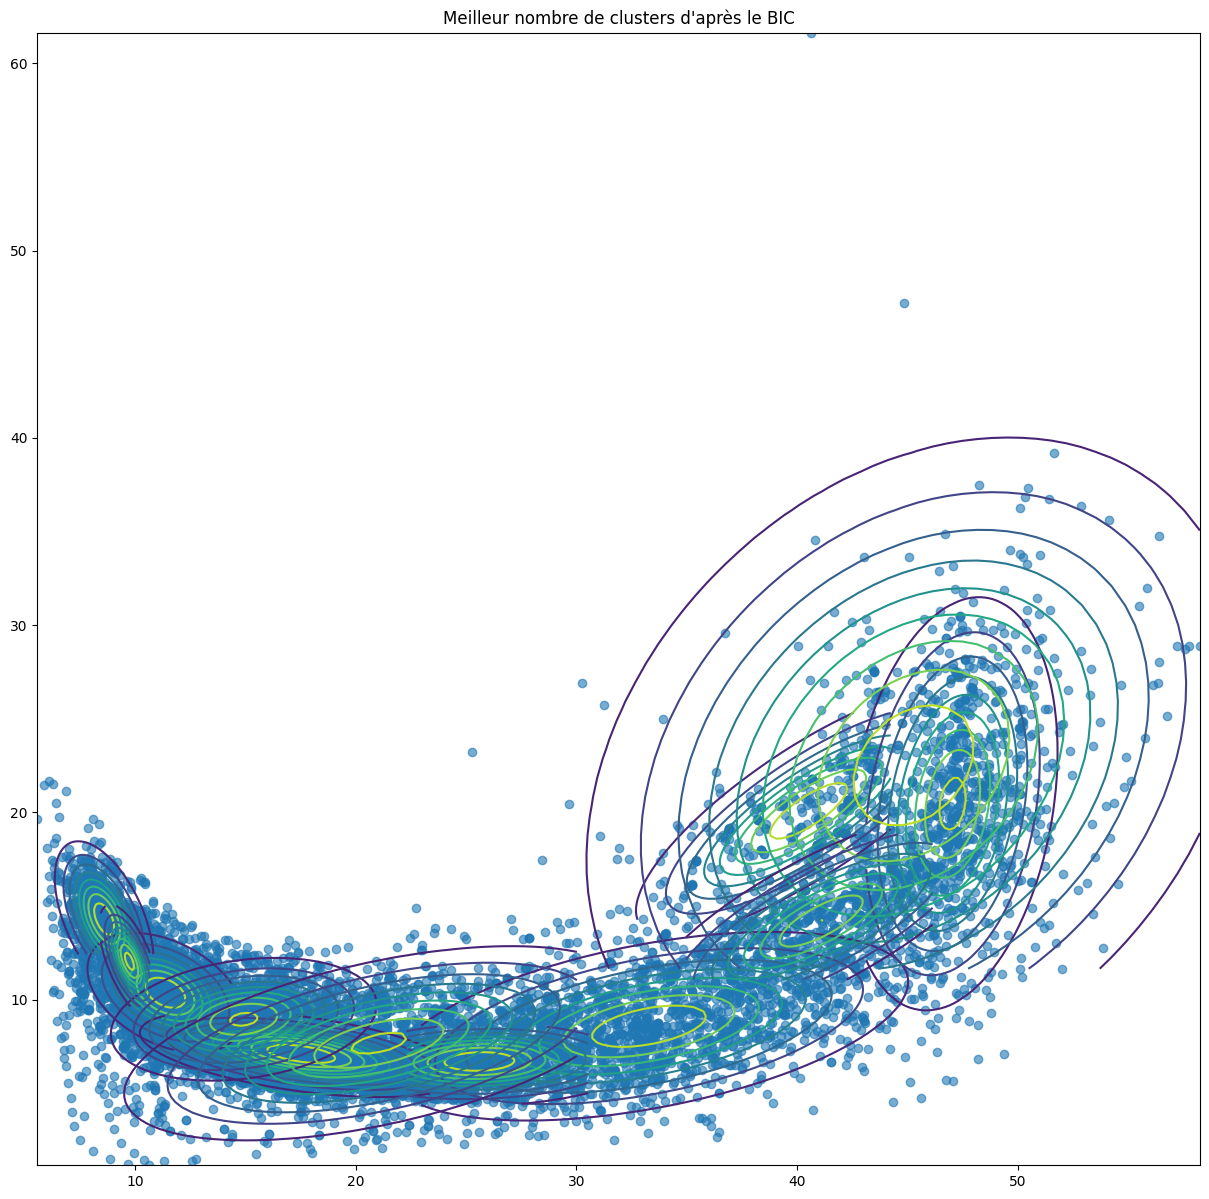

In [47]:
Gaussian_contour_2d(data19,results19[best-1],title="Meilleur nombre de clusters d'après le BIC")

### On voit bien que le nombre de clusters est aberrant
C'est probablement dû à la log-vraisemblance qui est assez faible (-75 000 à la convergence), ce qui rend la "pénalité" induite par le nombre de clusters assez négligeable.

En effet, la pénalité évolue en $\propto 5*\text{dof}(p)$ Avec des degrés de liberté entre 5 et 100 environ, ce qui est très loin en ordre de grandeur des 75 000 de log-vraisemblance.

# Exercice 3 - Importance sampling

In [22]:
def f(x):
    fun=2*np.sin((2*(np.pi)/3)*x) if x>=0 else 0
    return fun

def p(x):
    fun=x**(0.65) * np.exp(-np.square(x)/2) if x>=0 else 0
    return fun
    
def q(x,mu,sigma):
    return 2*stats.norm.pdf(x,loc=mu,scale=sigma) if x>=0 else 0

In [23]:
def poor_IS(N,mu,sigma,f=f,p=p,q=q,normalize=True):
    #Ici on utilise la loi q renormalisée ie N(0.8,1.5)
    x=np.random.normal(size=N,loc=mu,scale=sigma)
    x=np.array(sorted(x[x>0]))
    W=np.ones(x.shape[0])
    f_x=[f(i) for i in x]
    p_x=[p(i) for i in x]
    q_x=[q(i,mu,sigma) for i in x]
    W=np.array(p_x)/np.array(q_x)
    if normalize:
    #On normalise les poids d'importance PAR LA MOYENNE car p n'est pas normalisée
        W=W/np.mean(W)
    return np.sum(np.array(W)*np.array(f_x))/x.shape[0],W,x

In [24]:
poor_IS(5000,0.8,np.sqrt(1.5))

(0.7310820566797636,
 array([0.02587519, 0.03235204, 0.04584848, ..., 0.00727101, 0.00372882,
        0.00329984]),
 array([7.37682725e-04, 1.04048573e-03, 1.78015930e-03, ...,
        5.08173072e+00, 5.39165384e+00, 5.44671297e+00]))

In [25]:
N=[10,100,1000,10000]
n_iter=100
exp=np.ones((n_iter,len(N)))
for count, n in enumerate(N):
    for i in range(n_iter):
        exp[i,count],w,x=poor_IS(n,0.8,np.sqrt(1.5))

In [26]:
for count, n in enumerate(N):
    print(f"Pour {n} échantillons:\nOn a une espérance pour f(x) de {np.mean(exp,0)[count]:.5f} en moyenne\nEt une variance de {np.var(exp,0)[count]:.3e}\n")

Pour 10 échantillons:
On a une espérance pour f(x) de 0.74996 en moyenne
Et une variance de 2.881e-01

Pour 100 échantillons:
On a une espérance pour f(x) de 0.76563 en moyenne
Et une variance de 2.307e-02

Pour 1000 échantillons:
On a une espérance pour f(x) de 0.76325 en moyenne
Et une variance de 2.228e-03

Pour 10000 échantillons:
On a une espérance pour f(x) de 0.77002 en moyenne
Et une variance de 1.929e-04



On voit bien que l'espérance de f(x) sous p semble converger vers 0.76 environ. Pour 10 000 échantillons tirés, on a une variance de 10-4 ce qui est tout à fait acceptable.

In [27]:
import scipy.integrate as integrate
numerical=integrate.quad(lambda x: f(x)*p(x),0,np.Infinity)
numerical

(0.7752953044208203, 5.88811237828896e-09)

La "vraie" espérance est assez proche de ce que nous obtenons mais pas égale,  c'est probablement dû à notre choix de q, qu'il faut optimiser.

In [28]:
N=[10,100,1000]
n_iter=100
exp=np.ones((n_iter,len(N)))
for count, n in enumerate(N):
    for i in range(n_iter):
        exp[i,count],w,x=poor_IS(n,6,np.sqrt(1.5))

In [29]:
for count, n in enumerate(N):
    print(f"Pour {n} échantillons:\nOn a une espérance pour f(x) de {np.mean(exp,0)[count]:.5f} en moyenne\nEt une variance de {np.var(exp,0)[count]:.3e}\n")

Pour 10 échantillons:
On a une espérance pour f(x) de 0.14654 en moyenne
Et une variance de 1.852e+00

Pour 100 échantillons:
On a une espérance pour f(x) de 0.06349 en moyenne
Et une variance de 1.752e+00

Pour 1000 échantillons:
On a une espérance pour f(x) de -1.03515 en moyenne
Et une variance de 5.228e-01



Les résultats sont aberrants et inconsistants car q n'est plus sur le support de p. Les poids d'importance $w=\dfrac{p}{q}$ n'ont donc plus de sens.
Il n'y a pas de convergence des moyenne, la variance est importante.

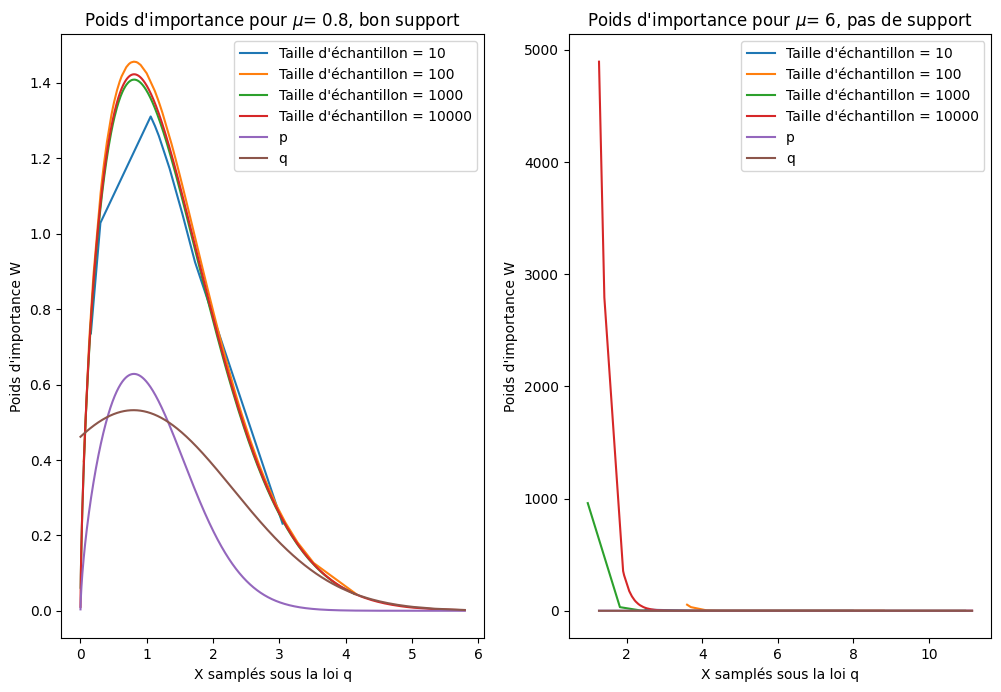

In [30]:
N=[10,100,1000,10000]
ax1=plt.subplot(121)
ax2=plt.subplot(122)
ax1.set_title("Poids d'importance pour $\mu$= 0.8, bon support")
ax2.set_title("Poids d'importance pour $\mu$= 6, pas de support")
for n in N:
    exp_supp,W_supp,x_supp=poor_IS(n,0.8,np.sqrt(1.5))
    exp_nosupp,W_nosupp,x_nosupp=poor_IS(n,6,np.sqrt(1.5))
    ax1.plot(x_supp, W_supp , label = 'Taille d\'échantillon = ' + str(n))
    ax2.plot(x_nosupp, W_nosupp , label = 'Taille d\'échantillon = ' + str(n))
    
p_x=[p(i) for i in x_supp]
q_x=[q(i,0.8,1.5) for i in x_supp]
ax1.plot(x_supp,p_x,label='p')
ax1.plot(x_supp,q_x,label='q')

p_x=[p(i) for i in x_nosupp]
q_x=[q(i,6,1.5) for i in x_nosupp]
ax2.plot(x_nosupp,p_x,label='p')
ax2.plot(x_nosupp,q_x,label='q')

ax1.legend()
ax2.legend()
ax1.set_xlabel("X samplés sous la loi q")
ax2.set_xlabel("X samplés sous la loi q")
ax1.set_ylabel("Poids d'importance W")
ax2.set_ylabel("Poids d'importance W")
plt.show()

On voit bien que les poids convergent si $\mu=0.8$ et restent bornés ($w=\dfrac{p(x)}{q(x)}<\gamma$). Les poids semblent maximaux quand p et q sont proches, p au-dessus de q.

Tandis que si $\mu=6$ il n'y a plus de support, les poids divergent très vite à gauche, et tendent très vite vers 0 à droite.

In [31]:
def banana_gaussian_sim(n,sigma,d,b):
    Sigma=np.eye(d)
    Sigma[0,0]=sigma**2
    mu=np.zeros(d)
    x=np.random.multivariate_normal(mu,Sigma,n)
    x[:,1]+=b*(np.square(x[:,0]) - np.square(sigma))
    return x

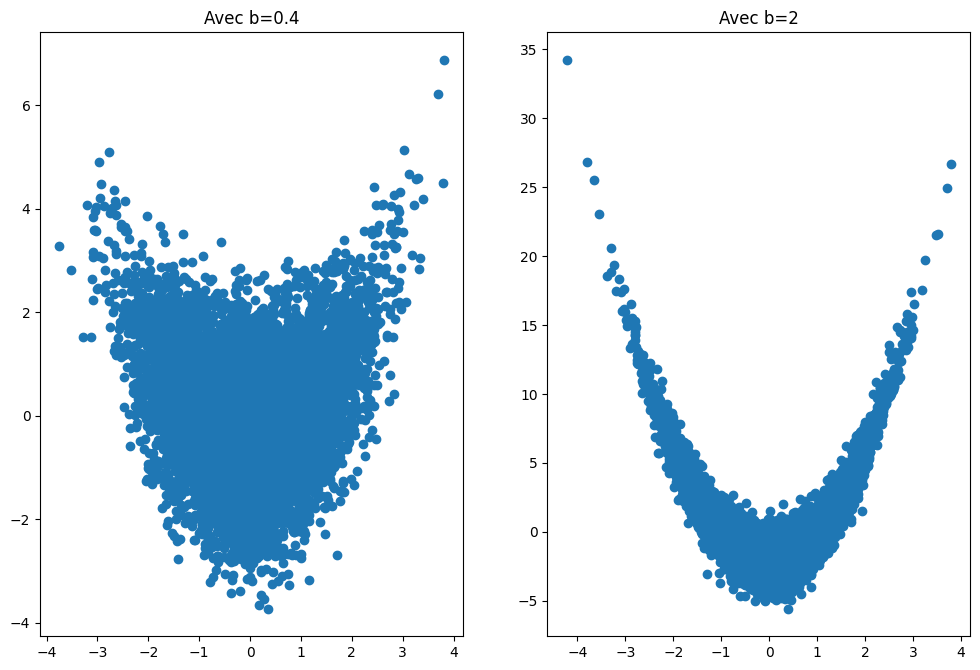

In [32]:
plt.subplot(121)
sim_banana=banana_gaussian_sim(10000,sigma=1,b=0.4,d=5)
plt.scatter(sim_banana[:,0],sim_banana[:,1])
plt.title("Avec b=0.4")
plt.subplot(122)
sim_banana=banana_gaussian_sim(10000,sigma=1,b=2,d=5)
plt.scatter(sim_banana[:,0],sim_banana[:,1])
plt.title("Avec b=2")
plt.show()

In [33]:
def banana_likelihood(x,sigma,d=5,b=0.4):
    Sigma=np.eye(d)
    Sigma[0,0]=sigma**2
    mu=np.zeros(d)
    sample=np.copy(x)
    #On veut la vraisemblance que ce soit une distribution banane donc on prend MOINS b(x2-s2)
    sample[:,1]-=b*(np.square(sample[:,0]) - np.square(sigma))
    tau=stats.multivariate_normal.pdf(sample,mu, Sigma)
    return tau


def IS_weights(data,alpha,mu,sigma,Cov,b=0.4,*,normalize_tau:bool = False, normalize_w:bool=True,allowsingularvalues:bool=False):
    d=data.shape[1]
    expect=Gaussian_Expect(data,alpha,mu,Cov,normalize=bool(normalize_tau),allowsingular=bool(allowsingularvalues))
    density=np.sum(expect,axis=1)
    w_tmp=np.array(banana_likelihood(data,sigma,d,b))/np.array(density)
    #Les 2 densités ne sont pas normalisées (densité banane connue à une constante de normalisation
    #près) donc on normalise les w
    if normalize_w:
        w=w_tmp/np.mean(w_tmp)
    else:
        w=w_tmp
    return w

In [34]:
def IS_Gaussian_Maxim(data,tau,w,epsilon=1e-5):
    sigma=[]
    mu=[]
    alpha_tmp=np.zeros(tau.shape[1])
    alpha_tmp=np.sum(tau,axis=0)
    alpha=alpha_tmp/np.sum(alpha_tmp)
    for j in range(tau.shape[1]):
        tau[:,j]=tau[:,j]*w
        #On rajoute un epsilon pour ne pas diviser par 0 lorsque les poids d'importance sont petits
        #(pas de support partagé entre les 2 distributions, cf plus haut=)
        mu.append(np.apply_along_axis(lambda x: np.average(x,weights=tau[:,j]+epsilon),0,data))
        sigma.append(((tau[:,j].reshape(-1,1)*(data-mu[j])).T@(data-mu[j]))/np.sum(tau[:,j]))
    sigma=np.array(sigma)
    mu=np.array(mu)
    return(dict(alpha=alpha,mu=mu,sigma=sigma))

In [35]:
def IS_EM_Gaussian(sigma,d,b,max_iter=100,clusters=3,n=1000,threshold=1e-10,method='numerical'):
    alpha=np.ones(clusters)/clusters
    BigSigma=[]
    mu=[]
    
    for i in range(clusters):
        random=np.random.rand(d,d)
        cov=np.dot(random.T,random)
        BigSigma.append(cov)   
        mu.append(np.random.uniform(-1,1,d))
        
    BigSigma=np.array(BigSigma)
    mu=np.array(mu)
    
    x=simu_gmm(n,alpha,mu,BigSigma,clusters=clusters,dimension=d)['sim']
    KL_Divergence_seq=np.zeros(max_iter)


    for i in range(max_iter):
            w  = IS_weights(x,alpha,mu,sigma,BigSigma,b,normalize_tau=False,normalize_w=True,allowsingularvalues=False)
            KL_Divergence_seq[i]=np.sum(np.log(w)*banana_likelihood(x,sigma,d=d,b=b))
            tau=Gaussian_Expect(x,alpha,mu,BigSigma,clusters,normalize=True,allowsingular=False,method=method)
            results=IS_Gaussian_Maxim(x,tau,w)
            mu=results["mu"]
            alpha=results["alpha"]
            BigSigma=results["sigma"]
            x=simu_gmm(n,alpha,mu,BigSigma,clusters=clusters,dimension=d)['sim']
    
    KL_Divergence_seq[-1]=np.sum(np.log(w)*banana_likelihood(x,sigma,d=d,b=b))
    tau=Gaussian_Expect(x,alpha,mu,BigSigma,clusters,normalize=False,allowsingular=True)
    clusterid=np.apply_along_axis(np.argmax,1,tau)
    return(dict(alpha=alpha,mu=mu,sigma=BigSigma,tau=tau,theta=[alpha,mu,BigSigma],clusterid=clusterid,weights=w,loglike=KL_Divergence_seq))

In [56]:
d=5
b=0.4
sigma=1
n=10000
results = IS_EM_Gaussian(sigma, d=d, b=b, max_iter=100,clusters=2,n=n,method='numerical')
simul_results=banana_gaussian_sim(n,d=d,b=b,sigma=sigma)

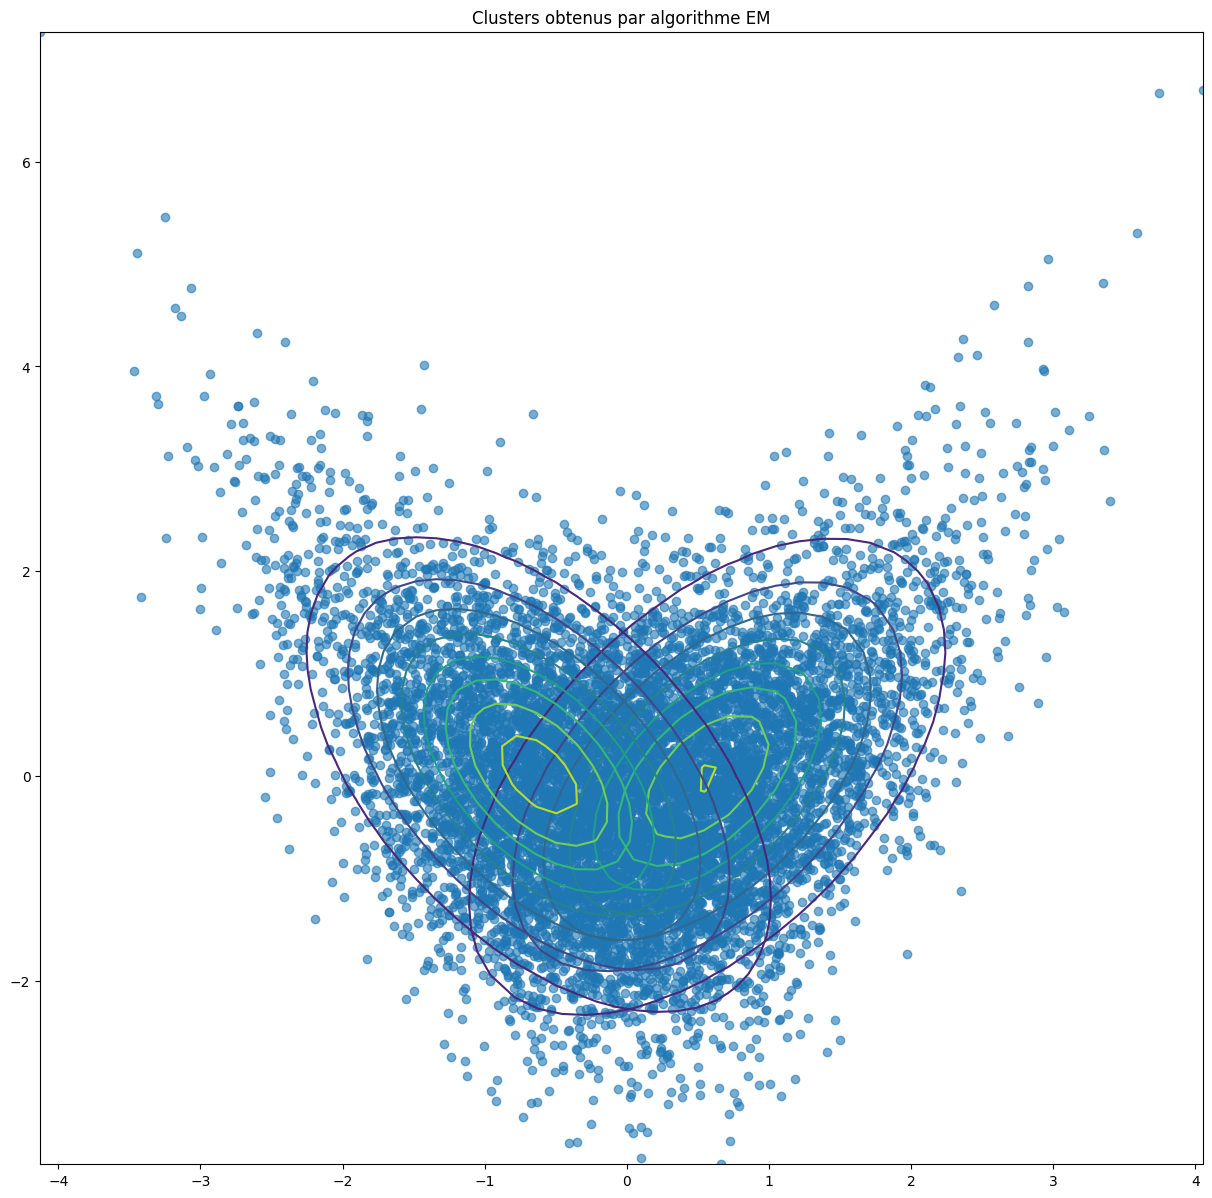

In [57]:
Gaussian_contour_2d(simul_results,results)

In [38]:
max_cluster=10
banane=[]
for i in range(max_cluster):
    banane.append(IS_EM_Gaussian(sigma, d=2, b=b, max_iter=100,clusters=i+1,n=n,method='scipy'))

In [53]:
best,value,bic=BIC(simul_results,banane,10)
BIC(simul_results,banane,10)

(3,
 81.2109877192216,
 [144.80585939645454,
  233.86685593451307,
  81.2109877192216,
  110.97345311852484,
  136.8422157158182,
  162.7420541453334,
  191.479207058471,
  217.41534692689055,
  247.58938155665865,
  273.5626172926944])

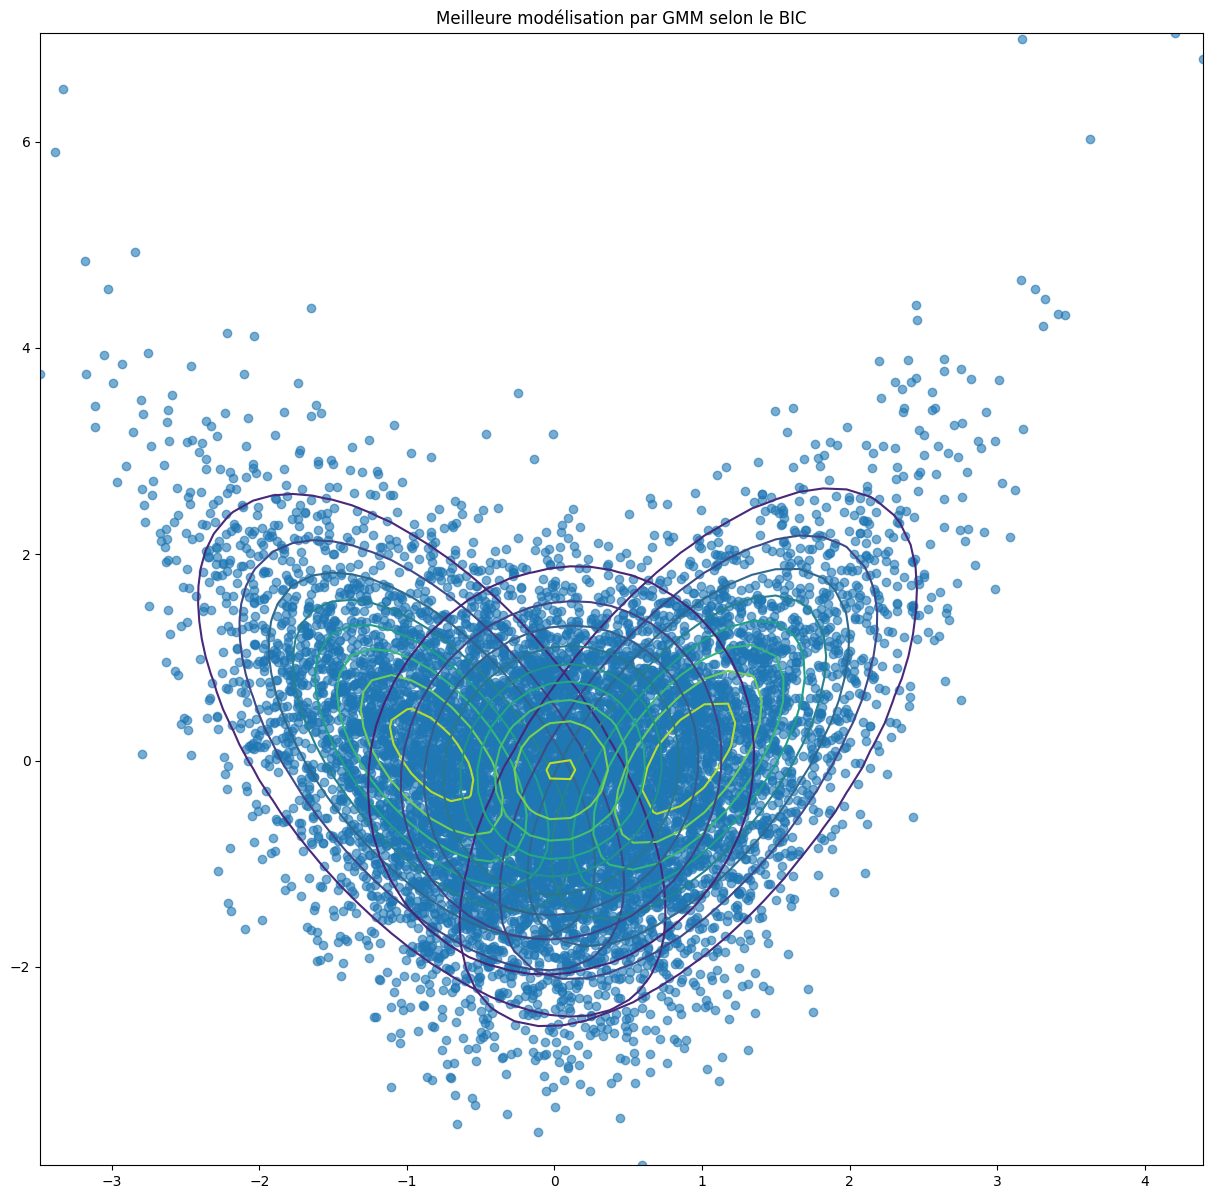

In [55]:
Gaussian_contour_2d(simul_results,banane[best-1],title="Meilleure modélisation par GMM selon le BIC")

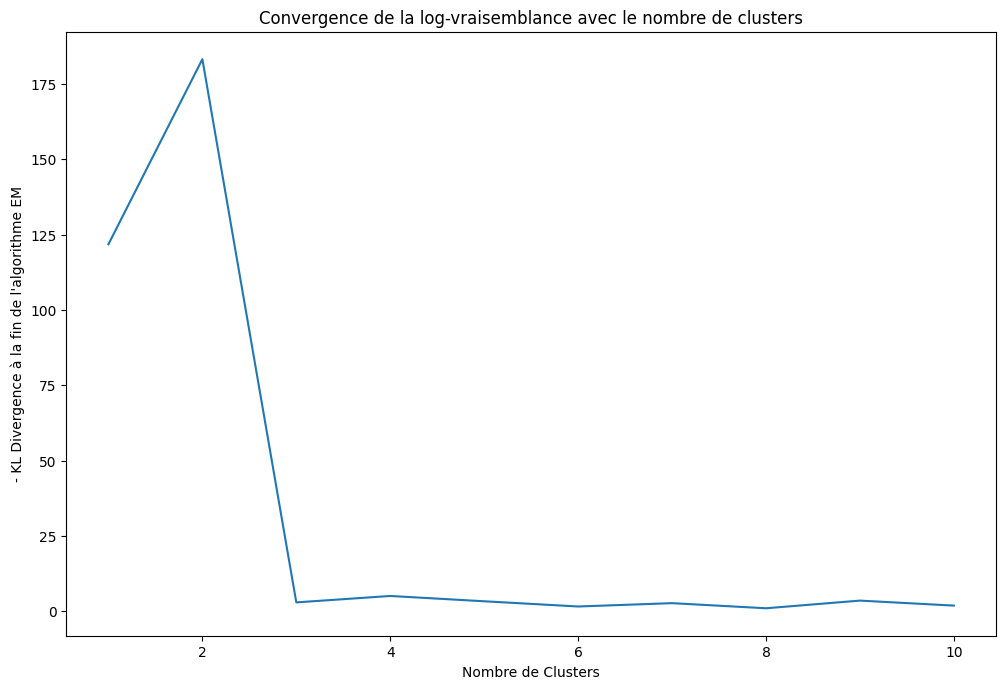

In [41]:
plt.plot(np.arange(1,max_cluster+1),[-1*banane[i]['loglike'][-1] for i in range(max_cluster)])
plt.xlabel('Nombre de Clusters')
plt.ylabel('- KL Divergence à la fin de l\'algorithme EM')
plt.title('Convergence de la log-vraisemblance avec le nombre de clusters')
plt.show()

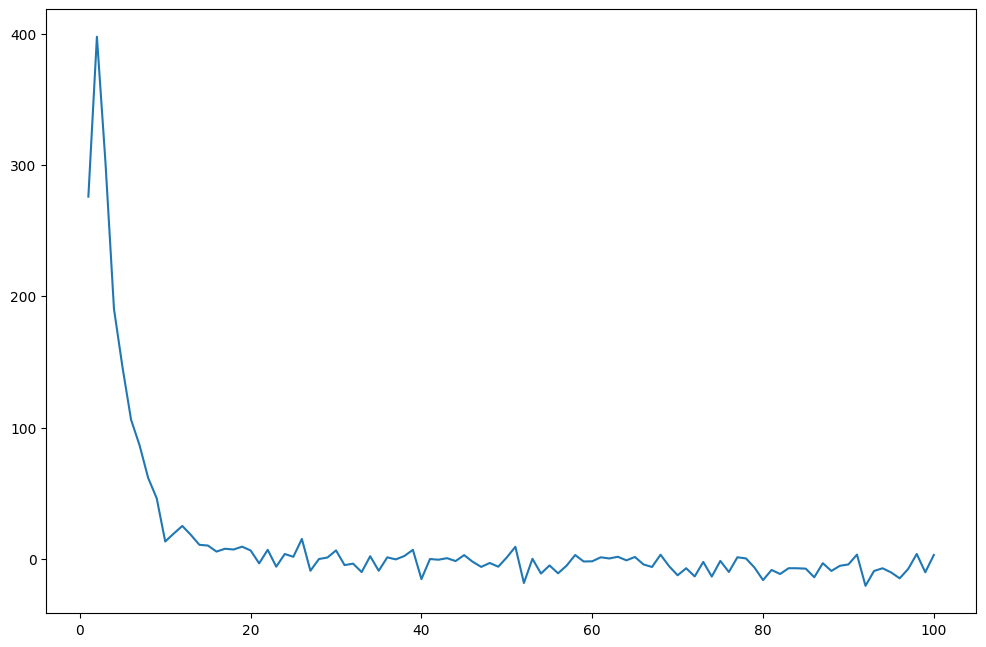

In [42]:
plt.plot(np.arange(1,max_iter+1),-banane[best-1]['loglike'])
plt.show()

On observe un gap important entre la 1e itération et la seconde car à la 1e la divergence de KL est basée sur des paramètres theta aléatoires. 